<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/quickhull_algo_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

In [9]:
def main(num_points):
  points = sorted([[rnd.random()*10, rnd.random()*10, rnd.random()*10] for _ in range(num_points)], key=lambda x: x[0])
  np_points = np.array(points)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(np_points[:,0], np_points[:,1], np_points[:,2])

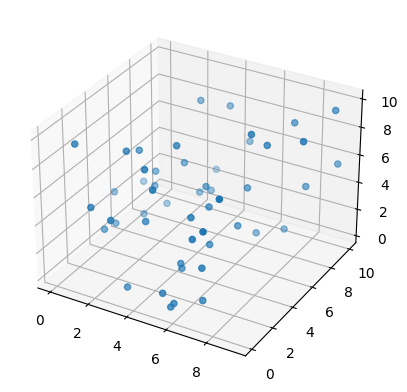

In [16]:
main(50)